<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind_from_stats, pearsonr
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re

In [19]:
# get files, clean them up
def clean_files(df):
    file = pd.read_csv(df, index_col = 0)
    file.index = file.index.str.strip()
    file = file[["2017", "2018", "2019", "2020", "2021"]]
    return file
    
violent_crime = clean_files("data_files/violent_crime_rates.csv")
property_crime = clean_files("data_files/property_crime_rates.csv")
unemployment = clean_files("data_files/unemployment.csv")
health_factors = clean_files("data_files/health_factors.csv")
health_outcomes = clean_files("data_files/health_outcomes.csv")
od_deaths = clean_files("data_files/od_death_rate_final.csv")
free_reduced_meals = clean_files("data_files/free_reduced_meals.csv")
graduation_rates = clean_files("data_files/graduation_rates.csv")
population = clean_files("data_files/population.csv")

In [20]:
# remove commas from data
def remove_commas(string):
    return re.sub(",", "", string)

for col in population.columns:
    population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
    
# remove percentage signs from data
def remove_percentage(string):
    return re.sub("%", "", string)

for col in free_reduced_meals.columns:
    free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_6115/254496132.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  population.loc[:,col] = population[col].astype(str).apply(remove_commas).astype(int)
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_6115/254496132.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  free_reduced_meals.loc[:,col] = free_reduced_meals[col].astype(str).apply(remove_percentage).astype(float)


In [21]:
def res_to_df(res):
    """
    Transform the result of an statsmodels results table to
    a pandas dataframe"""
    pvals = res.pvalues
    coeff = res.params
    conf_lower = res.conf_int()[0]
    conf_higher = res.conf_int()[1]
    df = pd.DataFrame(
        {
            "pvals": pvals,
            "coeff": coeff,
            "conf_lower": conf_lower,
            "conf_higher": conf_higher,
        }
    )
    cols = ["coeff", "pvals", "conf_lower", "conf_higher"]
    df = df[cols]
    df.reset_index(inplace=True)
    df.columns = ["name"] + cols
    return df

In [22]:
# convert crime rates from numbers to per capita
violent_crime.astype(int)
per_capita_crime = violent_crime / population

property_crime.astype(int)
per_capita_property_crime = property_crime / population


In [23]:
# unstack all the dataframes and rename their columns
per_capita_violent_all = per_capita_crime.unstack().reset_index()
per_capita_property_all = per_capita_property_crime.unstack().reset_index()
unemployment_all = unemployment.unstack().reset_index()
health_factors_all = health_factors.unstack().reset_index()
health_outcomes_all = health_outcomes.unstack().reset_index()
od_deaths_all = od_deaths.unstack().reset_index()
free_reduced_meals_all = free_reduced_meals.unstack().reset_index()
graduation_rates_all = graduation_rates.unstack().reset_index()

per_capita_violent_all.columns = ['year', 'county', 'violent_crime_rate']
per_capita_property_all.columns = ['year', 'county', 'property_crime_rate']
unemployment_all.columns = ['year', 'county', 'unemployment']
health_factors_all.columns = ['year', 'county', 'health_factors']
health_outcomes_all.columns = ['year', 'county', 'health_outcomes']
od_deaths_all.columns = ['year', 'county', 'od_deaths']
free_reduced_meals_all.columns = ['year', 'county', 'free_reduced_meals']
graduation_rates_all.columns = ['year', 'county', 'graduation_rate']

def combine_dfs(df_list):
    main_df = per_capita_violent_all
    for df in df_list:
        main_df = pd.merge(main_df, df)
    return main_df

clean_data = combine_dfs([per_capita_property_all, unemployment_all, health_factors_all, 
                          health_outcomes_all, od_deaths_all, graduation_rates_all, free_reduced_meals_all])


In [24]:
def plot_rates(x, y, title, xlabel, ylabel):
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [25]:
clean_data

,year,county,violent_crime_rate,property_crime_rate,unemployment,health_factors,health_outcomes,od_deaths,graduation_rate,free_reduced_meals
0,2017,Alameda,0.000407,0.001327,3.1,6.0,8.0,7.060,77.633333,43.9
1,2017,Alpine,0.011649,0.025986,4.1,NaN,NaN,0.000,NaN,72.5
2,2017,Amador,0.002257,0.009235,4.4,19.0,23.0,8.775,82.433333,46.3
3,2017,Butte,0.000704,0.005374,5.2,37.0,36.0,18.935,74.558824,59.1
4,2017,Calaveras,0.004380,0.012878,4.1,22.0,24.0,10.512,87.610000,54.3
...,...,...,...,...,...,...,...,...,...,...
285,2021,Tulare,0.000727,0.003700,8.1,57.0,47.0,16.630,81.527778,75.3
286,2021,Tuolumne,0.005140,0.010046,5.0,23.0,31.0,27.705,78.160000,45.8
287,2021,Ventura,0.000123,0.000877,4.2,16.0,12.0,30.915,75.905556,51.8
288,2021,Yolo,0.000266,0.001587,4.1,13.0,10.0,12.560,87.076471,53.8


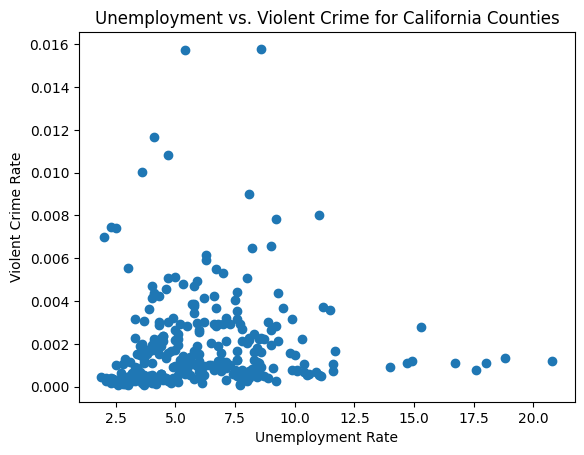

In [26]:
plot_rates(clean_data.unemployment, clean_data.violent_crime_rate, 
           "Unemployment vs. Violent Crime for California Counties",
          "Unemployment Rate", "Violent Crime Rate")


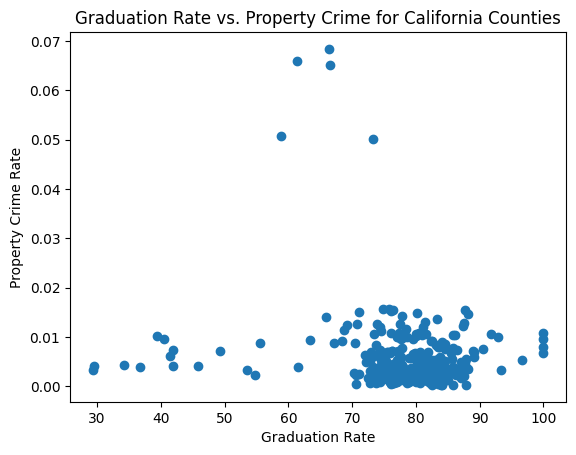

In [27]:
plot_rates(clean_data.graduation_rate, clean_data.property_crime_rate, 
           "Graduation Rate vs. Property Crime for California Counties",
          "Graduation Rate", "Property Crime Rate")

In [82]:
X = clean_data[['year', 'unemployment']].astype(float)
y = clean_data['violent_crime_rate']

In [34]:
fit = smf.ols(
    "violent_crime_rate ~ 1 + unemployment + od_deaths",
    clean_data,
).fit(cov_type="HC1")
res = res_to_df(fit).set_index("name")
res

,coeff,pvals,conf_lower,conf_higher
name,,,,
Intercept,-0.000433,2.369265e-01,-0.001150,0.000284
property_crime_rate,0.148982,5.367367e-08,0.095293,0.202671
unemployment,0.000073,7.077095e-03,0.000020,0.000127
od_deaths,0.000044,4.680671e-03,0.000014,0.000075


In [37]:
fit = smf.ols(
    "violent_crime_rate ~ 1 + unemployment + od_deaths",
    clean_data,
).fit(cov_type="HC1")
res = res_to_df(fit).set_index("name")
res

,coeff,pvals,conf_lower,conf_higher
name,,,,
Intercept,0.000262,0.550198,-0.000598,0.001123
unemployment,0.000047,0.170518,-0.000020,0.000115
od_deaths,0.000063,0.000131,0.000031,0.000096


In [38]:
fit.rsquared

0.19759177843792353

In [28]:
clean_data.head()

,year,county,violent_crime_rate,property_crime_rate,unemployment,health_factors,health_outcomes,od_deaths,graduation_rate,free_reduced_meals
0,2017,Alameda,0.000407,0.001327,3.1,6.0,8.0,7.060,77.633333,43.9
1,2017,Alpine,0.011649,0.025986,4.1,NaN,NaN,0.000,NaN,72.5
2,2017,Amador,0.002257,0.009235,4.4,19.0,23.0,8.775,82.433333,46.3
3,2017,Butte,0.000704,0.005374,5.2,37.0,36.0,18.935,74.558824,59.1
4,2017,Calaveras,0.004380,0.012878,4.1,22.0,24.0,10.512,87.610000,54.3


In [39]:
fit = smf.ols(
    "violent_crime_rate ~ 1 + unemployment + health_factors + health_outcomes + od_deaths + graduation_rate + free_reduced_meals + C(year)",
    clean_data,
).fit(cov_type="HC1")
res = res_to_df(fit).set_index("name")
res

,coeff,pvals,conf_lower,conf_higher
name,,,,
Intercept,0.003228,2.390100e-05,0.001730,0.004725
C(year)[T.2018],-0.000181,4.996754e-01,-0.000706,0.000344
C(year)[T.2019],-0.000302,2.134355e-01,-0.000777,0.000174
C(year)[T.2020],-0.000639,3.947548e-02,-0.001247,-0.000031
C(year)[T.2021],-0.000433,1.377100e-01,-0.001004,0.000139
unemployment,0.000104,1.930642e-02,0.000017,0.000191
health_factors,-0.000050,2.064155e-03,-0.000082,-0.000018
health_outcomes,0.000078,6.296134e-09,0.000052,0.000104
od_deaths,0.000029,5.595086e-04,0.000013,0.000046


In [40]:
fit.rsquared

0.3806665918914529